# Q Learning From Scratch in Python

In this tutorial you will: 
1. Implement Q learning in Python from scratch.

2. Train and evaluate the Q Learning agent for playing on a frozen lake, driving a taxi and taking it on a cliff walk.


Let's look at the Q Learning pseudocode first:

<font color='blue'>**Q Learning Pseudocode**:<font>
    
    
Input:  step size $\alpha$ withing range (0, 1], small $\gamma$ > 0


Initialize for all $s\in S$ and $a\in A$:    
>$Q(s, a)$ <- arbitrary  

Loop for each episode until S is terminal: 
>initialize S
    
>loop for each step of episode:
>>choose A from S using policy derived from Q (epsilon greedy)
    
>>take action A, observe R, S'
    
>>$Q(s, a)$ <- $Q(s, a)$  + $\alpha$[R + $\gamma$ max_a Q(S', a) - Q(S, a)]

>> S = S'


 



# Packages

For this tutorial we will use:
1. **gym**: this library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms.
2. **numpy**: the fundamental package for scientific computing with Python;
4. **bokeh**: library for creating interactive visualizations;
5. **time**: module that provides various time-related functions;

*To run this notebook, make sure you have installed these packages.*

In [2]:
import gymnasium as gym
import numpy as np
import time
import random
from typing import Tuple, Union


from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

env_name = 'FrozenLake-v1'


Loading BokehJS ...

Below you can find utility function and class, please run the cell to load them too.

In [31]:
def render_single(env, policy, max_steps=100):
    """
    Renders policy for an environment.

    Parameters
    ----------
    env:    gym.core.Environment, open gym environment object
    policy: np.array of shape [env.nS], the action to take at a given state
    """
    episode_reward = 0
    state = env.reset()[0]
    for t in range(max_steps):
        env.render()
        time.sleep(0.25)
        print(state)
        a = policy[state]
        state, reward, done, _, _= env.step(a)
        episode_reward += reward
        if done:
            break
    env.render();
    if not done:
        print("The agent didn't reach a terminal state in {} steps.".format(max_steps))
    else:
        print("Episode reward: %f" % episode_reward)
        
        
class Evaluator:
    """Provides methods to log output data and calculate metrics for Q Learning class."""
    def __init__(self):
        self.__sum_of_rewards_per_episode = [0]
        self.__episode_len = [0]

    def log_metrics_per_episode(self, reward, episode):
        """Logs sum of rewards per episode and episode length."""
        if (episode + 1) > len(self.__sum_of_rewards_per_episode):
            self.__sum_of_rewards_per_episode.append(0)
            self.__episode_len.append(0)
        self.__sum_of_rewards_per_episode[episode] += reward
        self.__episode_len[episode] += 1

    @property
    def sum_of_rewards_per_episode(self):
        return self.__sum_of_rewards_per_episode
    
    @property
    def episode_len(self):
        return self.__episode_len
    
    
class Visualizer:
    def __init__(self, evaluator: Evaluator, width=800, height=250):
        self.evaluator = evaluator
        self.width = width
        self.height = height
        
    def plot_sum_of_rewards(self):
        p = figure(
            title="Sum of rewards",
            plot_width=self.width,
            plot_height=self.height,
            x_axis_label="Episodes",
            y_axis_label="Average sum of rewards during episode"
        )
        p.line(range(1, n_episodes + 1), evaluator.sum_of_rewards_per_episode, line_width=1)

        return p
    
    def plot_episode_len(self):
        p = figure(
            title="Episode Length",
            plot_width=self.width,
            plot_height=self.height,
            x_axis_label="Episodes",
            y_axis_label="Episode length"
        )
        p.line(range(1, n_episodes + 1), evaluator.episode_len, line_width=1)

        return p

## Q Learning implementation
We will create class called QLearning that will implement the Q learning control algorithm.

In [4]:
class QLearning:
    """Implements Off-policy control with Q Learning."""

    def __init__(self, env: gym.Env, num_states: int, num_actions: int, alpha: float, epsilon: float,
                 gamma: float):
        """Parameters
        ----------
        env:         gym.core.Environment, open gym environment object
        num_states:  integer, number of states in the environment
        num_actions: integer, number of possible actions
        alpha:       float, step size, (0, 1]
        epsilon:     float, the epsilon parameter used for exploration
        gamma:       float, discount factor, small > 0
        """
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        self.Q = np.zeros((self.num_states, self.num_actions))

        self.env.reset()

    def run_q_learning(self, num_episodes: int, evaluator: Evaluator) -> list[int]:
        """Runs Q learning

        Parameters
        ----------
        num_episodes: integer, number of episodes to run to train RL agent
        evaluator:    instance of Evaluator class, necessary for logging output data and creating evaluation metrics.

        Returns
        ----------
        self.final_policy: list of integers of length self.num_states, final policy
        """
        terminated = False
        for i in range(num_episodes):
            self.env.reset()
            state = np.random.choice(self.num_states, 1)[0]
            terminated = False
            while not terminated:
                action, next_state, reward, terminated = self.generate_next_step(state)
                evaluator.log_metrics_per_episode(reward, i)
                if not isinstance(next_state, int):
                    raise TypeError('Integer is expected as a next state')
                self.evaluate_policy(state, action, reward, next_state)

                state = next_state

        # Once training is finished, calculate and return policy using argmax approach
        final_policy = np.argmax(self.Q, axis=1)

        return final_policy

    def generate_next_step(self, state: int) -> Tuple[Union[int, float, bool]]:
        """Generates action in state and outcome (next_state, reward, terminated)of taking this action.

        Parameters
        ----------
        state: int, current state of the agent

        Returns
        ----------
        action:      int, action that agent takes in state
        observation: object, observation as a result of agent taking action in state, format is specific to the environment
        reward:      float
        terminated:  bool, whether a terminal state (as defined under the MDP of the task) is reached.
        """
        random_action = self.env.action_space.sample()
        action = self.get_epsilon_greedy_action(state, random_action)

        observation, reward, terminated, _, _ = self.env.step(action)

        return action, observation, reward, terminated

    def get_epsilon_greedy_action(self, state: int, random_action: int) -> int:
        """Returns next action using epsilon greedy approach.

        Parameters
        ----------
        state:         int, current state
        random_action: int, action sampled from current state

        Returns
        ----------
        next_action: int, either greedy or random action
        """
        prob = np.random.random()

        if prob < (1 - self.epsilon):
            return self.argmax(state)

        return random_action

    def evaluate_policy(self, state: int, action: int, reward: float, next_state: int):
        """Updates Q value for a specific state and action pair.

        Parameters
        ----------
        state:      int, current state
        action:     int, action taken in state
        reward:     float, reward as a result of taking action in state
        next_state: int
        """
        est_reward = reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state][action] = self.Q[state][action] + self.alpha * (est_reward - self.Q[state][action])

    def argmax(self, state: int) -> int:
        """
        Finds and returns greedy action.

        Parameters
        ----------
        state: int, state for which greedy action should be selected

        Returns
        ----------
        action: int, corresponds to the index of the greedy action

        """
        return int(np.argmax(self.Q[state]))


# Tests

Below you will find tests, run them to make make sure that Q Learning implementation is correct.

In [11]:
import ipytest
import pytest
ipytest.autoconfig()

In [16]:
%%ipytest -qq

np.random.seed(1)
 
@pytest.fixture
def this_env():
    env = gym.make('FrozenLake-v1', is_slippery=False)
    
    yield env

@pytest.fixture
def q_learning_instance(this_env):
    alpha = 1
    epsilon = 0.8
    gamma = 1
    num_states = this_env.observation_space.n
    num_actions = this_env.action_space.n
    yield QLearning(this_env, num_states, num_actions, alpha, epsilon, gamma)
    

def test_argmax(q_learning_instance):
    res = q_learning_instance.argmax(0)
    assert isinstance(res, int)
    assert res == 0
    
    
def test_get_epsilon_greedy_action(q_learning_instance):
    action = q_learning_instance.get_epsilon_greedy_action(0, 3)
    assert isinstance(action, int)
    action == 0
  
    
def test_argmax(this_env, q_learning_instance):
    action = q_learning_instance.argmax(1)
    assert action < this_env.observation_space.n
    assert action >= 0

    
def test_evaluate_policy(this_env, q_learning_instance):
    q_learning_instance.Q = np.zeros((q_learning_instance.num_states, q_learning_instance.num_actions))
    q_learning_instance.Q[1][3] = 10
    
    state = 2
    action = 1
    reward = 5
    next_state = 1
    
    q_learning_instance.evaluate_policy(state, action, reward, next_state)
    assert q_learning_instance.Q[state][action] == 15
    

...                                                                                          [100%]


# Frozen lake

In [32]:
np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='ansi')
# env.seed(11)
np.random.seed(1)
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

# set_random_seeds(env)
model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)
evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)


Starting environment with 16 states and 4 actions


In [8]:
render_single(env, policy, 200)

0
1
2
6
10
14
Episode reward: 1.000000


In [33]:
vis = Visualizer(evaluator)

show(vis.plot_sum_of_rewards())
show(vis.plot_episode_len())

<AxesSubplot: >

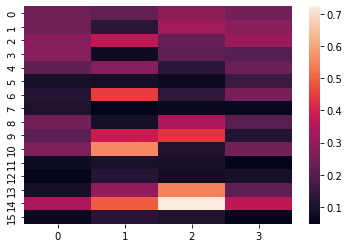

In [30]:
import seaborn
seaborn.heatmap(model.Q)

# Cliff Walking

In [34]:
np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('CliffWalking-v0')
np.random.seed(1)
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)

evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)

Starting environment with 48 states and 4 actions


In [35]:
render_single(env, policy, 200)

36
24
25
26
27
28
29
30
31
32
33
34
35
Episode reward: -13.000000


In [36]:
vis = Visualizer(evaluator)

show(vis.plot_sum_of_rewards())
show(vis.plot_episode_len())

# Taxi Problem

In [37]:
np.random.seed(1)

alpha = 0.1
epsilon = 0.9
gamma = 0.9
n_episodes = 1000

env = gym.make('Taxi-v3')
num_states = env.observation_space.n
num_actions = env.action_space.n
print(f"Starting environment with {num_states} states and {num_actions} actions")

model = QLearning(env, num_states, num_actions, alpha, epsilon, gamma)

evaluator = Evaluator()
policy = model.run_q_learning(n_episodes, evaluator)

Starting environment with 500 states and 6 actions


In [38]:
render_single(env, policy, 200)

73
173
273
373
473
477
377
277
297
197
97
Episode reward: 10.000000


In [39]:
vis = Visualizer(evaluator)

show(vis.plot_sum_of_rewards())
show(vis.plot_episode_len())